In [ ]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
figsize=(12,5)
data_train = pd.read_csv('all/train.csv')

In [78]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [79]:
data_train.loc[(data_train.Age.isnull()),'Age'] = data_train.Age.mean()
def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df
data_train = set_Cabin_type(data_train)
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')

dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')

a = data_train.Age
factor=pd.cut(a,[0,15,70,100],labels=['Age_young','Age_adult','Age_old']) #用cut函数来分段向量，在把数据映射到其中，得到0-1向量
b = pd.get_dummies(factor)

df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass,b], axis=1)
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1,1))
df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1,1), fare_scale_param)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked','Fare','Age'], axis=1, inplace=True)


In [80]:
from sklearn import linear_model

# 用正则取出我们要的属性值
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.values

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)

clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

In [72]:
pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

,columns,coef
0,SibSp,[-0.38503732209051017]
1,Parch,[-0.21287044791302845]
2,Cabin_No,[-0.4345479389904147]
3,Cabin_Yes,[0.40166408900235734]
4,Embarked_C,[0.0]
5,Embarked_Q,[0.0]
6,Embarked_S,[-0.39151648601748346]
7,Sex_female,[2.321754225013425]
8,Sex_male,[-0.36959836350826863]
9,Pclass_1,[0.014785940912525282]


In [81]:
data_test = pd.read_csv("all/test.csv")
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0
# 接着我们对test_data做和train_data中一致的特征变换
# 首先用同样的RandomForestRegressor模型填上丢失的年龄
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
data_test.loc[(data_test.Age.isnull()),'Age'] = data_test.Age.mean()

data_test = set_Cabin_type(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')
a = data_test.Age
factor=pd.cut(a,[0,15,70,100],labels=['Age_young','Age_adult','Age_old']) #用cut函数来分段向量，在把数据映射到其中，得到0-1向量
b = pd.get_dummies(factor)

df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass,b], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df_test['Fare_scaled'] = scaler.fit_transform(df_test['Fare'].values.reshape(-1,1), fare_scale_param)
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
test
predictions = clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.to_csv("all/logistic_regression_predictions_age_old_70_optim.csv", index=False)

In [ ]:
fig = plt.figure(figsize=figsize)
fig.set(alpha=0.65) # 设置图像透明度，无所谓
plt.title(u"根据舱等级和性别的获救情况")

ax1=fig.add_subplot(141)
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass != 3].value_counts().plot(kind='bar', label="female highclass", color='#FA2479')
ax1.set_xticklabels([u"获救", u"未获救"], rotation=0)
ax1.legend([u"女性/高级舱"], loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass == 3].value_counts().plot(kind='bar', label='female, low class', color='pink')
ax2.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"女性/低级舱"], loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass != 3].value_counts().plot(kind='bar', label='male, high class',color='lightblue')
ax3.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"男性/高级舱"], loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass == 3].value_counts().plot(kind='bar', label='male low class', color='steelblue')
ax4.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"男性/低级舱"], loc='best')



plt.show()

In [ ]:
g

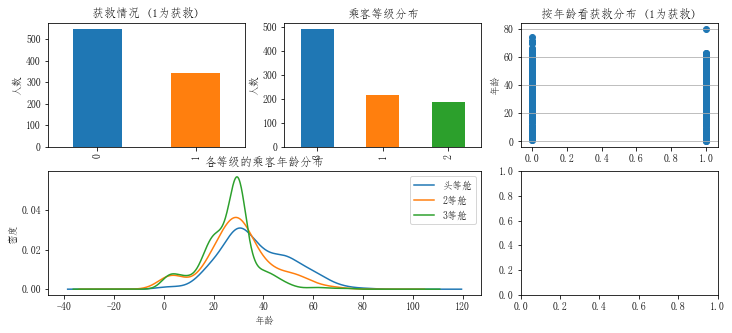

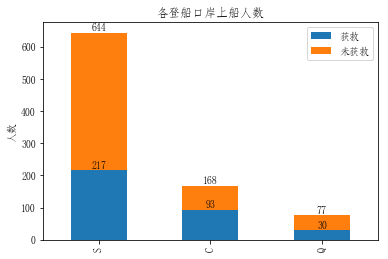

In [45]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
import matplotlib.pyplot as plt
fig = plt.figure(figsize=figsize)
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

plt.subplot2grid((2,3),(0,0))             # 在一张大图里分列几个小图
data_train.Survived.value_counts().plot(kind='bar')# 柱状图 
plt.title(u"获救情况 (1为获救)") # 标题
plt.ylabel(u"人数")  

plt.subplot2grid((2,3),(0,1))
data_train.Pclass.value_counts().plot(kind="bar")
plt.ylabel(u"人数")
plt.title(u"乘客等级分布")

plt.subplot2grid((2,3),(0,2))
plt.scatter(data_train.Survived, data_train.Age)
plt.ylabel(u"年龄")                         # 设定纵坐标名称
plt.grid(b=True, which='major', axis='y') 
plt.title(u"按年龄看获救分布 (1为获救)")


plt.subplot2grid((2,3),(1,0), colspan=2)
data_train.Age[data_train.Pclass == 1].plot(kind='kde')   
data_train.Age[data_train.Pclass == 2].plot(kind='kde')
data_train.Age[data_train.Pclass == 3].plot(kind='kde')
plt.xlabel(u"年龄")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"各等级的乘客年龄分布")
plt.legend((u'头等舱', u'2等舱',u'3等舱'),loc='best') # sets our legend for our graph.


plt.subplot2grid((2,3),(1,2))
Survived_1 = data_train.Embarked[data_train.Survived == 1].value_counts()
Survived_0 = data_train.Embarked[data_train.Survived == 0].value_counts()
x = np.arange(3)
y1 = np.array(list(Survived_1))
y2 = np.array(list(Survived_0+Survived_1))
tdf = pd.DataFrame({u'获救':Survived_1,u'未获救':Survived_0})
tdf.plot(kind='bar',stacked=True)
for a,b in zip(x,y1):
    plt.text(a,b+0.05,'%.f' % b, ha = 'center',va = 'bottom',fontsize=10)
for a,b in zip(x,y2):
    plt.text(a,b+0.05,'%.f' % b, ha = 'center',va = 'bottom',fontsize=10)
plt.title(u"各登船口岸上船人数")
plt.ylabel(u"人数")  
plt.show()

<Figure size 432x288 with 0 Axes>

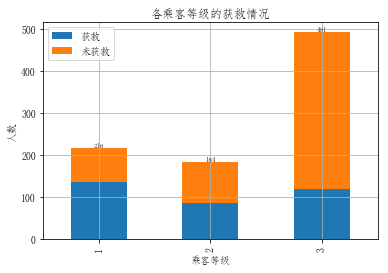

In [39]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_0 = data_train.Pclass[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Pclass[data_train.Survived == 1].value_counts()
df=pd.DataFrame({u'获救':Survived_1, u'未获救':Survived_0})
df.plot(kind='bar', stacked=True)
x = np.arange(3)
y = np.array(list(Survived_0+Survived_1))
for a,b in zip(x,y):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=7)
plt.grid(True)
plt.title(u"各乘客等级的获救情况")
plt.xlabel(u"乘客等级") 
plt.ylabel(u"人数") 
plt.show()

In [ ]:
g = data_train.groupby(['SibSp','Survived'])
df = pd.DataFrame(g.count()['PassengerId'])
print(df)